# 介紹

線性迴歸**擅長推斷趨勢，但無法學習交互作用**。 XGBoost **擅長學習交互，但無法推斷趨勢**。在本課中，我們將學習如何創建“混合(Hybrid)”預測器，將互補的學習算法結合起來，讓一個的優勢彌補另一個的弱點。

# 成分(Components)和殘差(Residuals) #

為了設計出有效的混合體，我們需要更好地理解時間序列是如何構建的。到目前為止，我們已經研究了三種依賴模式：趨勢、季節和周期。許多時間序列可以通過僅由這三個成分加上一些本質上不可預測的、完全隨機的*誤差*的加法模型來密切描述：

```
系列 = 趨勢 + 季節 + 週期 + 誤差
```

這個模型中的每一個術語我們都可以稱為時間序列的**成分**。

模型的**殘差(residuals)**是模型訓練的目標與模型做出的預測之間的差異——換句話說，實際曲線和擬合曲線之間的差異。根據特徵繪製殘差，你會得到目標的“剩餘”部分，或者模型未能從該特徵中了解目標的內容。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/mIeeaBD.png" width=700, alt="">
<figcaption style="textalign: center; font-style: italic"><center>目標序列和預測（藍色）之間的差異給出了殘差序列。
</center></figcaption>
</figure>

上圖左側是*Tunnel Traffic* 系列的一部分和第 3 課中的趨勢-季節性曲線。減去擬合曲線後，殘差在右側。殘差包含來自 *Tunnel Traffic* 趨勢季節性模型沒有學習的所有內容。

我們可以將學習時間序列的組成部分想像為一個迭代過程：首先學習趨勢並將其從序列中減去，然後從去趨勢的殘差中學習季節性並減去季節，然後學習週期並減去週期，最後只剩下不可預知的誤差。(透過特徵慢慢減少殘差)

<figure style="padding: 1em;">
<img src="https://i.imgur.com/XGJuheO.png" width=700, alt="">
<figcaption style="textalign: center; font-style: italic"><center>逐步學習<em>Mauna Loa CO2的成分</em>。從其序列中減去擬合曲線（藍色）以獲得下一步中的系列。
</center></figcaption>
</figure>

將我們學到的所有成分加在一起，我們就得到了完整的模型。如果您在一組完整的特徵建模趨勢、季節和周期上對其進行訓練，這基本上就是線性迴歸會做的事情。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/HZEhuHF.png" 寬度=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>添加學習到的成分得到一個完整的模型。
</center></figcaption>
</figure>

# 殘差混合預測 #

在之前的課程中，我們使用單一算法（線性迴歸）一次學習所有成分。但也可以**對某些成分使用一種算法，而對其餘成分使用另一種算法**。這樣，我們總是可以為每個成分選擇最佳算法。為此，我們使用一種算法來擬合原始序列，然後使用第二種算法來擬合殘差序列。

詳細來說，流程是這樣的：
```
# 1. 使用第一個模型進行訓練和預測
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. 使用第二個模型對殘差進行訓練和預測
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. 添加以獲得整體預測
y_pred = y_pred_1 + y_pred_2
```

我們通常希望使用不同的特徵集（上面的`X_train_1`和`X_train_2`），這取決於**我們希望每個模型學習什麼**。例如，如果我們使用第一個模型來學習趨勢，我們通常不需要第二個模型的趨勢特徵。**(每個模型獨立學習不同特徵)**

雖然可以使用兩個以上的模型，但實際上它似乎並不是特別有用。事實上，構建混合模型的最常見策略就是我們剛剛描述的：**一個簡單（通常是線性）學習算法，然後是一個複雜的非線性學習器**，如 GBDT 或深度神經網絡，簡單模型通常設計為後面強大算法的“助手”。

### 設計混合模型

除了我們在本課中概述的方式之外，還有很多方法可以組合機器學習模型。然而，成功地組合模型需要我們更深入地研究這些算法是如何運作的。

迴歸算法通常可以通過兩種方式進行預測：要麼轉換*特徵*，要麼轉換*目標*。**特徵轉換算法學習一些將特徵作為輸入的數學函數**，然後將它們組合和轉換以產生與訓練集中的目標值匹配的輸出。線性迴歸和神經網絡就是這種類型。

**目標變換算法使用這些特徵對訓練集中的目標值進行分組，並通過對組中的值進行平均來進行預測**；一組特徵只是指示要平均哪個組。決策樹和最近鄰就是這種類型。

重要的是：給定適當的特徵作為輸入，特徵轉換器通常可以**外推(extrapolate)**目標值超出訓練集，但**目標轉換器的預測將始終限制在訓練集的範圍內**。如果時間虛擬變量繼續計算時間步長，則線性迴歸繼續繪製趨勢線。給定相同的時間虛擬變量，決策樹將永遠預測訓練數據的最後一步所指示的趨勢到未來。 *決策樹無法推斷趨勢。* 隨機森林和梯度提升決策樹（如 XGBoost）是決策樹的集合，因此它們也無法推斷趨勢。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/ZZtfuFJ.png" 寬度=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>決策樹無法推斷訓練集之外的趨勢。
</center></figcaption>
</figure>

這種差異是本課混合設計的動機：*使用線性迴歸來推斷趨勢，轉換 target 以消除趨勢，並將 XGBoost 應用於去趨勢的殘差。*要混合神經網絡（特徵轉換器），您可以將另一個模型的預測作為特徵包含在內，然後神經網絡會將其作為其自身預測的一部分。擬合殘差的方法其實和梯度提升算法使用的方法是一樣的，所以我們稱這些**boosted**hybrids；使用預測作為特徵的方法稱為“堆疊(stacking)”，因此我們將這些 **stacked** 稱為混合體。

<blockquote style="margin-right:auto; margin-left:auto; background-color: #000000; padding: 1em; margin:24px;">
<strong>在 Kaggle 比賽中獲獎</strong>
    <p>為了獲得靈感，這裡有一些過去比賽中得分最高的解決方案：</p>
<ul>
    <li><a href="https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/discussion/8125">STL 通過指數平滑提升</a> - Walmart Recruiting - Store Sales預測</li>
    <li><a href="https://www.kaggle.com/c/rossmann-store-sales/discussion/17896">GBDT 增強了 ARIMA 和指數平滑</a> - Rossmann Store Sales</li>
    <li><a href="https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/39395">堆疊和提升混合動力的集合</a> - 網絡流量時間系列預測</li>
    <li><a href="https://github.com/Mcompetitions/M4-methods/blob/slaweks_ES-RNN/118%20-%20slaweks17/ES_RNN_SlawekSmyl.pdf">指數平滑與 LSTM 神經網絡堆疊</a > - M4（非 Kaggle）</li>
</ul>
</blockquote>

# 範例 - 美國零售額 #

[*US Retail Sales*](https://www.census.gov/retail/index.html) 數據集包含美國人口普查局收集的 1992 年至 2019 年各個零售行業的月度銷售數據。我們的目標是根據早些年的銷售額預測 2016-2019 年的銷售額。除了創建線性迴歸 + XGBoost 混合，我們還將了解如何設置用於 XGBoost 的時間序列數據集。

In [1]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

data_dir = Path("./data_set/")
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

首先讓我們使用線性迴歸模型來學習每個系列的趨勢。 為了演示，我們將使用二次（2 階）趨勢。 （這裡的代碼和上一課的代碼基本相同。）雖然合身並不完美，但足以滿足我們的需要。

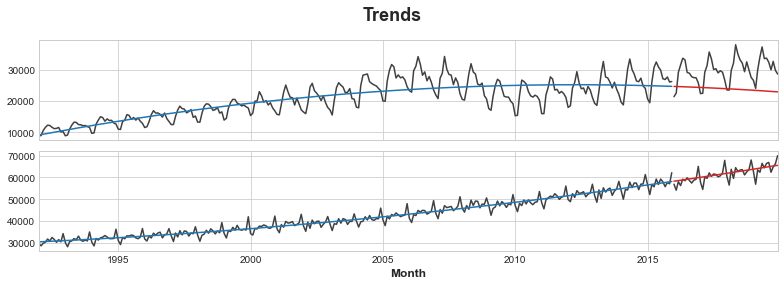

In [5]:

y = retail.copy()

# 創建趨勢特徵
dp = DeterministicProcess(
    index=y.index,  # 來自訓練數據的日期
    constant=True,  # 截距
    order=2,        # 二次方趨勢
    drop=True,      # 刪除項以避免共線性
)
X = dp.in_sample()  # 訓練數據的特徵

# 測試 2016-2019 年。 如果我們直接拆分日期索引而不是數據框，我們以後會更容易。
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

雖然線性迴歸算法能夠進行多輸出迴歸，但 XGBoost 算法卻不能。 為了使用 XGBoost 一次預測多個系列，我們將把這些系列從 *wide* 格式（每列一個時間系列）轉換為 *long* 格式，系列按行的類別索引。

In [6]:
# `stack` 方法將列標籤轉換為行標籤，從寬格式轉換為長格式
X = retail.stack()  # 將數據集從寬轉長
display(X.head())
y = X.pop('Sales')  # 抓出目標序列

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

為了讓 XGBoost 能夠學會區分我們的兩個時間序列，我們將`“Industries”`的行標籤轉換為帶有標籤編碼的分類特徵。 我們還將通過從時間索引中提取月份數字來創建年度季節性特徵。

In [7]:
# 使用標籤編碼將行標籤轉換為分類特徵列
X = X.reset_index('Industries')
# “Industries”特徵的標籤編碼
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# 年度季度性的標籤編碼
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

現在我們將之前所做的趨勢預測轉換為長格式，然後從原始系列中減去它們。 這將為我們提供 XGBoost 可以學習的去趨勢（殘差）序列。

In [8]:
# 將寬軸旋轉為長軸（stack）並將 DataFrame 轉換為系列（squeeze）
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# 從訓練集中創建殘差（去趨勢系列的集合）
y_resid = y_train - y_fit

# 在殘差上訓練 XGBoost
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# 將預測殘差添加到預測趨勢上
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

擬合看起來相當好，儘管我們可以看到 XGBoost 學習到的趨勢與線性回歸學習到的趨勢一樣好——特別是 XGBoost 無法補償“BuildingMaterials”中的不良擬合趨勢 '`系列。

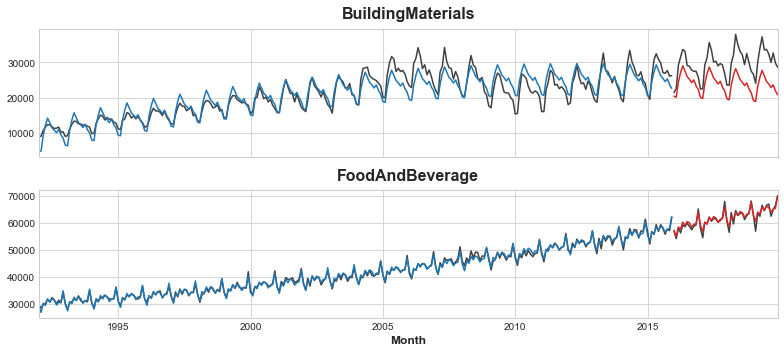

In [9]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

# EXERCISE #

[**Forecast Store Sales**](https://www.kaggle.com/kernels/fork/19616007) with an XGBoost hybrid and try out other combinations of ML algorithms.